# Лабораторна робота №4
## Завдання 2

Провести класифікацію даних з датасету titanic.csv, що використовувася у ЛР №2. Оскільки нам з попередньої лабораторної роботи відомо, що датасет має не праивльний ствопчик виживших, а саме всі жінки вижили, а всі чоловіки -- ні, я прийняв рішення використати інший датасет, що об'єднує дані з оригінлального та дані з вікіпедії. Посилання на датасет: https://www.kaggle.com/datasets/pavlofesenko/titanic-extended

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data
df = pd.read_csv('titanic-extended.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,WikiId,Name_wiki,Age_wiki,Hometown,Boarded,Destination,Lifeboat,Body,Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,691.0,"Braund, Mr. Owen Harris",22.0,"Bridgerule, Devon, England",Southampton,"Qu'Appelle Valley, Saskatchewan, Canada",NaN,NaN,3.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,90.0,"Cumings, Mrs. Florence Briggs (née Thayer)",35.0,"New York, New York, US",Cherbourg,"New York, New York, US",4,NaN,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,865.0,"Heikkinen, Miss Laina",26.0,"Jyväskylä, Finland",Southampton,New York City,14?,NaN,3.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,127.0,"Futrelle, Mrs. Lily May (née Peel)",35.0,"Scituate, Massachusetts, US",Southampton,"Scituate, Massachusetts, US",D,NaN,1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,627.0,"Allen, Mr. William Henry",35.0,"Birmingham, West Midlands, England",Southampton,New York City,NaN,NaN,3.0


### Попередня обробка датасету

In [3]:
# Select features
X = df[['Pclass', 'Age_wiki', 'Sex', 'Fare', 'Embarked', 'Survived']].copy()

# Rename Age_wiki to Age
X.rename(columns={'Age_wiki': 'Age'}, inplace=True)

# Map Sex to 0 and 1
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

# Map Embarked to 0, 1, and 2
X['Embarked'] = X['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

X.head()

,Pclass,Age,Sex,Fare,Embarked,Survived
0,3,22.0,0,7.2500,0.0,0.0
1,1,35.0,1,71.2833,1.0,1.0
2,3,26.0,1,7.9250,0.0,1.0
3,1,35.0,1,53.1000,0.0,1.0
4,3,35.0,0,8.0500,0.0,0.0


In [4]:
# Check for missing values
X.isnull().sum()

Pclass        0
Age           7
Sex           0
Fare          1
Embarked      2
Survived    418
dtype: int64

In [5]:
# Drop missing values in Survived and Embarked
X = X.dropna(subset=['Survived', 'Embarked'])

# Fill missing values in Age and Fare with median
X['Age'] = X['Age'].fillna(X['Age'].median(skipna=True))
X['Fare'] = X['Fare'].fillna(X['Fare'].median(skipna=True))

X = X.apply(pd.to_numeric, errors='coerce')

# Check for missing values
X.isnull().sum()

Pclass      0
Age         0
Sex         0
Fare        0
Embarked    0
Survived    0
dtype: int64

In [6]:
# Check data types
X.dtypes

Pclass        int64
Age         float64
Sex           int64
Fare        float64
Embarked    float64
Survived    float64
dtype: object

In [7]:
# Summary statistics
print('Dataset shape:', X.shape)
X.describe()

Dataset shape: (889, 6)


,Pclass,Age,Sex,Fare,Embarked,Survived
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.311586,29.269595,0.350956,32.096681,0.362205,0.382452
std,0.834700,13.868241,0.477538,49.697504,0.636157,0.486260
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,7.895800,0.000000,0.000000
50%,3.000000,28.000000,0.000000,14.454200,0.000000,0.000000
75%,3.000000,37.000000,1.000000,31.000000,1.000000,1.000000
max,3.000000,74.000000,1.000000,512.329200,2.000000,1.000000


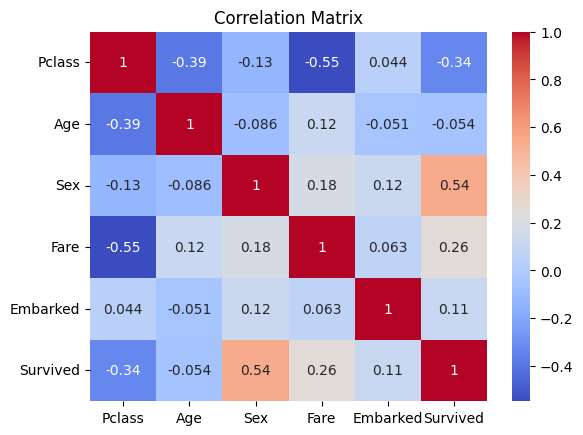

In [8]:
# Correlation matrix
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

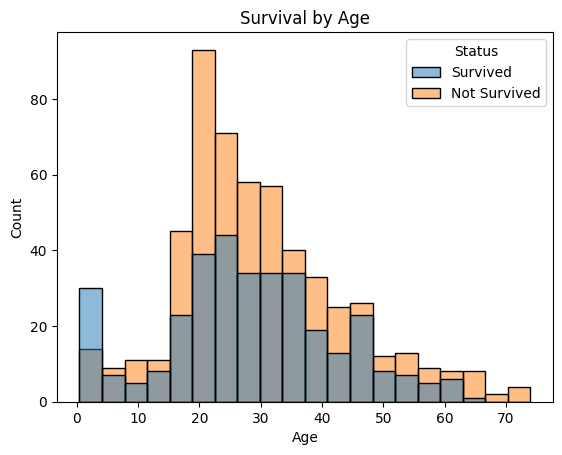

In [9]:
df_survived = X.loc[X['Survived'] == 1, ['Age']].copy()
df_survived['Status'] = 'Survived'

df_not_survived = X.loc[X['Survived'] == 0, ['Age']].copy()
df_not_survived['Status'] = 'Not Survived'

df_combined = pd.concat([df_survived, df_not_survived])

# Plot the histogram with hue
sns.histplot(data=df_combined, x='Age', hue='Status', bins=20)
plt.title('Survival by Age')
plt.show()

У порівняні зі старим датасетом, тут пік загиблих зсунувся до 20-23 років з 28-30. Також вищі шанси на виживання серед найменших дітей більш виражені.

### Побудова моделей

In [11]:
# Split data into features and target
y = X['Survived']
X_features = X.copy().drop(columns=['Survived'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a dictionary of classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVC': SVC(),
}

# Create dictionary of hyperparameters
params = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': [None, 'l2'],
        },
    'Decision Tree': {
        'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
        'min_samples_split': [2, 4, 6, 8, 10, 20, 40],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32]
        },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': [0.1, 0.01],
        'kernel': ['rbf']
        }
}

# Train the models
best_models = {}
for key, classifier in classifiers.items():
    grid = GridSearchCV(classifier, params[key], cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[key] = grid.best_estimator_
    print(f'{key} best parameters: {grid.best_params_}')

Logistic Regression best parameters: {'C': 1, 'penalty': 'l2'}
Decision Tree best parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}
SVC best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [12]:
# Evaluate the models
for key, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f'{key} accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'{key} confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
    print(f'{key} classification report:\n{classification_report(y_test, y_pred)}')
    print('--------------------------------------------------')

Logistic Regression accuracy: 0.7808988764044944
Logistic Regression confusion matrix:
[[87 22]
 [17 52]]
Logistic Regression classification report:
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       109
         1.0       0.70      0.75      0.73        69

    accuracy                           0.78       178
   macro avg       0.77      0.78      0.77       178
weighted avg       0.78      0.78      0.78       178

--------------------------------------------------
Decision Tree accuracy: 0.8314606741573034
Decision Tree confusion matrix:
[[95 14]
 [16 53]]
Decision Tree classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86       109
         1.0       0.79      0.77      0.78        69

    accuracy                           0.83       178
   macro avg       0.82      0.82      0.82       178
weighted avg       0.83      0.83      0.83       178

---------------

### Аналіз оцінки
Загалом найкращий результат показало Дерево рішень з точністю 83%. Це один з найкращих результатів, що вдалося отримати з різних комбінацій ознак та параметрів тренування.

In [19]:
#np.random.seed(42)
random_indices = np.random.choice(X_test.shape[0], 10, replace=False)
X_sample = X_test[random_indices]
y_sample = y_test.iloc[random_indices]

y_sample_pred = best_models['Decision Tree'].predict(X_sample)

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Sample Index': random_indices,
    'Actual': y_sample,
    'Predicted': y_sample_pred
})

comparison_df

,Sample Index,Actual,Predicted
193,120,1.0,1.0
583,33,0.0,0.0
110,152,0.0,0.0
209,45,1.0,0.0
397,40,0.0,0.0
466,117,0.0,0.0
842,81,1.0,1.0
446,54,1.0,1.0
535,50,1.0,1.0
360,34,0.0,0.0
